# Training for Brain Tumour Segmentation Prediction

This notebook contains all the code necessary to train a pipeline model to predict for Brain Tumour Segmentation from 3D MRI scans. The pipeline contains 2 models, a Convolutional Autoencoder and an U-Net model.

The Convolutional Autoencoder deals with locating the tumour if it was detected by the model. The U-Net model is then used to predict segmentation class given a cropped scan of the tumour.

The input data is split into 2D scans of the brains, this allows for our models to have much simplier architectures, smaller amount of weights to train and the pipeline model will be suitable to predict for 2D and 3D scans.

The training data are available from The 2021 Brain Tumour Segmentation (BraTS) Challenge. The dataset is contains MRI scans for 1251 patients and 4 modalities each, this amounts to over 5000 3D images which each have dimensions 240 × 240 × 155. In this notebook, we will focus on the FLAIR modality which results in the best accuracy from our models.

The training data can be downloaded from [Kaggle](https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1), the data should be pasted into the directory as shown below

```
.
├── train.ipynb
├── utilities.py
├── preprocessing_utilities.py
└── BraTS/
    └── BraTS2021_Training_Data/
        ├── BraTS2021_00000/
        │   ├── BraTS2021_00000_flair.nii.gz
        │   ├── BraTS2021_00000_seg.nii.gz
        │   ├── BraTS2021_00000_t1.nii.gz
        │   ├── BraTS2021_00000_t1ce.nii.gz
        │   └── BraTS2021_00000_t2.nii.gz
        ├── BraTS2021_00002/
        │   └── ...
        ├── BraTS2021_00003/
        │   └── ...
        └── ...
```

## Import libraries

In [1]:
import os, random, time, multiprocessing, glob, cv2, numpy as np, pandas as pd, nibabel as nib, matplotlib.pylab as plt

# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
# Torchvision library
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from utilities import *
from preprocessing_utilities import *

## User defined parameters

In [2]:
SEED = 44
USE_SEED = True
N_EPOCHS_CAE = 40
N_EPOCHS_UNet = 50
batch_size = 64
scan_type = 'Flair'

master_path = r'./BraTS/'
folders = [folder for folder in os.listdir(os.path.join(master_path, 'BraTS2021_Training_Data')) if folder != '.DS_Store']

## Split the dataset

This list needs to be reserved so we will have the same subsets of data for the training task between the 2 models

In [3]:
dataset_indices = list(range(len(folders)))
train_indices, test_indices = train_test_split(dataset_indices, test_size=0.1, random_state=SEED)
train_indices, val_indices = train_test_split(train_indices, test_size=0.22, random_state=SEED)

train_folders = [folders[i] for i in train_indices]
valid_folders = [folders[i] for i in val_indices]
test_folders = [folders[i] for i in test_indices]

## Torch Device configuration

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
   device = torch.device('mps')
else:
    device = torch.device('cpu')

def set_seed(seed, use_cuda = True, use_mps = False):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    if use_mps:
        torch.mps.manual_seed(seed)

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available(), torch.backends.mps.is_available())

# Convolutional Autoencoder

## Preprocessing

The preprocessing step is done outside of PyTorch, so the work won't need to be repeated every time we train the model. This preprocessing code is done for all modalities and we utilise the `multiprocessing' library to increase performance.

Please skip this if the preprocessing process has already been done.

In [ ]:
# Check if the data is already converted

if not os.path.exists(os.path.join(master_path, 'BraTS2021_Training_Data_Slice')):
    os.makedirs(os.path.join(master_path, 'BraTS2021_Training_Data_Slice'), exist_ok=True)
    for folder in folders:
        os.makedirs(os.path.join(master_path, 'BraTS2021_Training_Data_Slice', folder), exist_ok=True)
        for img_type in ['flair', 'seg', 't1', 't1ce', 't2']:
            os.makedirs(os.path.join(master_path, 'BraTS2021_Training_Data_Slice', folder, img_type), exist_ok=True)

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())  # Use all available CPU cores
    pool.map(convert, folders)
    pool.close()
    pool.join()

## Define Custom Dataset

In [7]:
class BraTSDataset(Dataset):
    def __init__(self, image_path = r'./BraTS/BraTS2021_Training_Data_Slice', transform=None):
        'Initialisation'
        self.image_path = image_path
        self.folders_name = [folder for folder in os.listdir(self.image_path) if folder != '.DS_Store']
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.folders_name) * 155

    def __getitem__(self, index):
        'Generates one sample of data'

        # Determine the image index and the RGB layer
        image_idx = index // 155
        layer_idx = index % 155

        # Select sample
        file_name = self.folders_name[image_idx]
        
        path_img = os.path.join(self.image_path, file_name, scan_type.lower(), file_name + '_' + scan_type.lower() + '_' + str(layer_idx+1) + '.npy')
        image = np.load(path_img).astype(np.float32)

        path_label = os.path.join(self.image_path, file_name, 'seg', file_name + '_seg_' + str(layer_idx+1) + '.npy')
        label = np.load(path_label)
        
        if self.transform:
            image, label = self.transform([image, label])
        return image, label

class BinariseLabel(object):
    def __call__(self, sample):
        image, label = sample
        new_label = np.sign(label)
        return image, new_label

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample

        # numpy image: H x W x C
        # torch image: C x H x W
        # image = image.transpose((2, 0, 1))
        return torch.from_numpy(image), torch.from_numpy(label)
    
dataset = BraTSDataset(image_path = r'./BraTS/BraTS2021_Training_Data_Slice',
                        transform=transforms.Compose([
                            BinariseLabel(),
                            ToTensor()
                        ]))

## Create DataLoaders for our 3 datasets

In [8]:
tmp_list = [[],[],[]]
for i, ind_list in enumerate([train_indices, val_indices, test_indices]):
    for ind in ind_list:
        for j in range(155):
            tmp_list[i].append(ind*155 + j)
train_indices, val_indices, test_indices = tmp_list

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

# Create the subset DataLoader
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

## Define Convlutional Autoencoder Model

In [9]:
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      ## encoder layers ##
      # conv layer (depth from 1 --> 4), 3x3 kernels
      # Input 64 x 64
      nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding = 'same'), # 64 x 64
      nn.ReLU(),
      # pooling layer to reduce x-y dims by two; kernel and stride of 2
      nn.MaxPool2d(2), ## 32 x 32
      # conv layer (depth from 4 --> 8), 4x4 kernels
      nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding = 'same'), # 32 x 32
      nn.ReLU(),
      nn.MaxPool2d(2), # 16 x 16
      # conv layer (depth from 8 --> 12), 5x5 kernels
      nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding = 'same'), # ( 12 x ) 16 x 16
      nn.ReLU(),
      
      ## decoder layers ##
      # add transpose conv layers, with relu activation function
      nn.ConvTranspose2d(12, 6, kernel_size = 2, stride=2), # 32 x 32
      nn.ReLU(),
      nn.ConvTranspose2d(6, 1, kernel_size = 2, stride=2), # 64 x 64
      # output layer (with sigmoid for scaling from 0 to 1)
      # nn.Sigmoid()
    )
    
  def forward(self, x):
    x = x.view(int(np.prod(x.shape)/(64**2)), 1, 64, 64)
    x = self.features(x)
    return x
  
model = ConvAutoencoder().to(device)

## Loss function and optimizer

In [10]:
# Loss
criterion = torch.nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

# Optim
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

## Training

In [ ]:
os.makedirs('./models', exist_ok=True)

train_losses, train_accs, valid_losses, valid_accs,\
    train_losses_batch, train_accs_batch, valid_losses_batch, valid_accs_batch = model_training(N_EPOCHS_CAE,
                                                                                                    model,
                                                                                                    train_dataloader,
                                                                                                    val_dataloader,
                                                                                                    optimizer,
                                                                                                    criterion,
                                                                                                    device,
                                                                                                    './models/CA_' + scan_type + '.pt')

## Save training, validation losses and accuracies

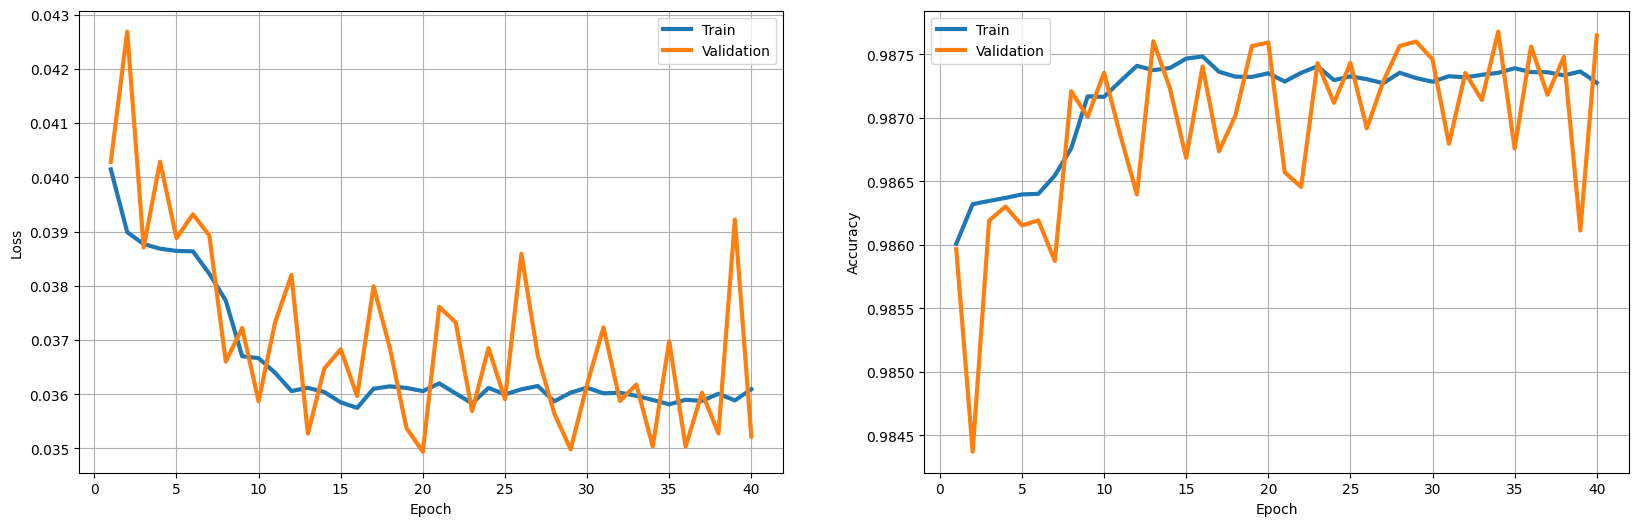

In [13]:
os.makedirs('./training_results', exist_ok=True)

pd.DataFrame({
    'Train Loss': train_losses,
    'Train Acc': train_accs,
    'Valid Loss': valid_losses,
    'Valid Acc': valid_accs
}).to_csv(f'./training_results/CA_{scan_type}.csv', index = False)

stacked_df = pd.concat([pd.DataFrame(pd.DataFrame(train_losses_batch).values.flatten(), columns=['Train Loss']),
                        pd.DataFrame(pd.DataFrame(train_accs_batch).values.flatten(), columns=['Train Acc']),
                        pd.DataFrame(pd.DataFrame(valid_losses_batch).values.flatten(), columns=['Valid Loss']),
                        pd.DataFrame(pd.DataFrame(valid_accs_batch).values.flatten(), columns=['Valid Acc'])], axis=1)
stacked_df.to_csv(f'./training_results/CA_{scan_type}_batch.csv', index = False)

plot_results(N_EPOCHS_CAE, train_losses, train_accs, valid_losses, valid_accs, save = True, save_name = f'./training_results/CA_{scan_type}.png')

## Performance on Test Set

In [ ]:
test_loss, test_acc, test_batch_loss, test_batch_acc = model_testing(model, test_dataloader, criterion, device, model_name=f'./models/CA_{scan_type}.pt')

stacked_df = pd.concat([pd.DataFrame(pd.DataFrame(test_batch_loss).values.flatten(), columns=['Test Loss']),
                        pd.DataFrame(pd.DataFrame(test_batch_acc).values.flatten(), columns=['Test Acc'])], axis=1)
stacked_df.to_csv(f'./training_results/CA_{scan_type}_test.csv', index = False)

# U-Net Model

## Preprocessing

Again, skip this if preprocessed data is already available.

In [ ]:
if not os.path.exists(os.path.join(master_path, 'BraTS2021_Training_Data_Slice_Cropped')):
    os.makedirs(os.path.join(master_path, 'BraTS2021_Training_Data_Slice_Cropped'), exist_ok=True)
    for dataset in ['train', 'valid', 'test']:
        os.makedirs(os.path.join(master_path, 'BraTS2021_Training_Data_Slice_Cropped', dataset), exist_ok=True)
        for img_type in ['flair', 'seg', 't1', 't1ce', 't2', 'cropped_area']:
            os.makedirs(os.path.join(master_path, 'BraTS2021_Training_Data_Slice_Cropped', dataset, img_type), exist_ok=True) 
    
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())  # Use all available CPU cores
    pool.map(convert_Unet_train, train_folders)
    pool.close()
    pool.join()

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())  # Use all available CPU cores
    pool.map(convert_Unet_valid, valid_folders)
    pool.close()
    pool.join()

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())  # Use all available CPU cores
    pool.map(convert_Unet_test, test_folders)
    pool.close()
    pool.join()

## Define Custom Dataset

In [15]:
train_images = np.sort([image for image in os.listdir(os.path.join('./BraTS/BraTS2021_Training_Data_Slice_Cropped', 'train', str(scan_type.lower()))) if image != '.DS_Store'])

class BraTSDataset(Dataset):
    def __init__(self, image_path = './BraTS/BraTS2021_Training_Data_Slice_Cropped', subset = 'train', transform = None):
        'Initialisation'
        self.image_path = os.path.join(image_path, subset)
        self.image_names = np.sort([image for image in os.listdir(os.path.join(self.image_path, str(scan_type.lower()))) if image != '.DS_Store'])
        self.labels_names = np.sort([image for image in os.listdir(os.path.join(self.image_path, 'seg')) if image != '.DS_Store'])
        self.transform = transform
    
    def get_id(self, index):
        return self.image_names[index]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.image_names)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Select sample
        image_name = self.image_names[index]
        label_name = self.labels_names[index]
        
        path_img = os.path.join(self.image_path, str(scan_type.lower()), image_name)
        path_label = os.path.join(self.image_path, 'seg', label_name)
        image = np.load(path_img).astype(np.float32)
        label = np.load(path_label)
        
        if self.transform:
            image, label = self.transform([image, label])
        return image, label

class OneHotLabel(object):
    def __call__(self, sample):
        image, label = sample
        new_label = np.zeros((64,64,4)) # 0,1,2,4
        for i, l in enumerate([0,1,2,4]):
            new_label[:,:,i] = (label == l)
        return image, new_label

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample
        image = np.float32(image)
        label = np.float32(label)

        # swap channel axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        new_label = label.transpose((2, 0, 1))
        return torch.from_numpy(image), torch.from_numpy(new_label)

## DataLoaders

In [16]:
dataset_train = BraTSDataset(transform = transforms.Compose([OneHotLabel(), ToTensor()]))
dataset_valid = BraTSDataset(subset = 'valid', transform = transforms.Compose([OneHotLabel(), ToTensor()]))
dataset_test = BraTSDataset(subset = 'test', transform = transforms.Compose([OneHotLabel(), ToTensor()]))

# Create the subset DataLoader
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## U-Net Model Architecture

In [17]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        ## Input is 32 x 32 x 1
        ## Output is 32 x 32 x 4
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3 32 x 32 x 1
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # output: 30x30x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, 4, kernel_size=1)

    def forward(self, x):
        x = x.view(x.shape[0], 1, 64, 64)
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

model = UNet().to(device)

## Loss function and optimizer

In [18]:
# Loss
criterion = torch.nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

# Optim
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

## Training

In [ ]:
train_losses, train_accs, valid_losses, valid_accs,\
    train_losses_batch, train_accs_batch, valid_losses_batch, valid_accs_batch = model_training(N_EPOCHS_UNet,
                                                                                    model,
                                                                                    train_dataloader,
                                                                                    val_dataloader,
                                                                                    optimizer,
                                                                                    criterion,
                                                                                    device,
                                                                                    f'./models/UNet_{scan_type}.pt')

## Save training, validation losses and accuracies

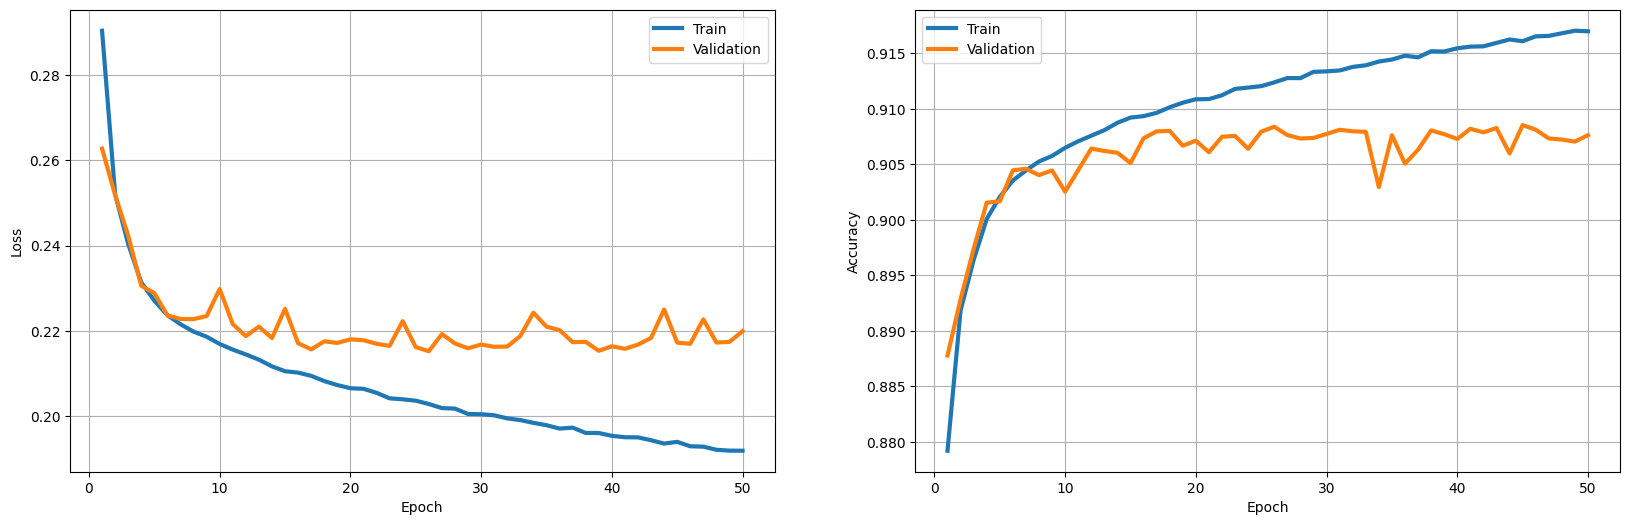

In [20]:
os.makedirs('./training_results', exist_ok=True)

pd.DataFrame({
    'Train Loss': train_losses,
    'Train Acc': train_accs,
    'Valid Loss': valid_losses,
    'Valid Acc': valid_accs
}).to_csv(f'./training_results/Unet_{scan_type}.csv', index = False)

stacked_df = pd.concat([pd.DataFrame(pd.DataFrame(train_losses_batch).values.flatten(), columns=['Train Loss']),
                        pd.DataFrame(pd.DataFrame(train_accs_batch).values.flatten(), columns=['Train Acc']),
                        pd.DataFrame(pd.DataFrame(valid_losses_batch).values.flatten(), columns=['Valid Loss']),
                        pd.DataFrame(pd.DataFrame(valid_accs_batch).values.flatten(), columns=['Valid Acc'])], axis=1)
stacked_df.to_csv(f'./training_results/Unet_{scan_type}_batch.csv', index = False)

plot_results(N_EPOCHS_UNet, train_losses, train_accs, valid_losses, valid_accs, save = True, save_name = f'./training_results/Unet_{scan_type}.png')

## Test Dataset

In [ ]:
test_loss, test_acc, test_batch_loss, test_batch_acc = model_testing(model, test_dataloader, criterion, device, model_name=f'./models/UNet_{scan_type}.pt')

stacked_df = pd.concat([pd.DataFrame(pd.DataFrame(test_batch_loss).values.flatten(), columns=['Test Loss']),
                        pd.DataFrame(pd.DataFrame(test_batch_acc).values.flatten(), columns=['Test Acc'])], axis=1)
stacked_df.to_csv(f'./training_results/UNet_{scan_type}_test.csv', index = False)